<a href="https://colab.research.google.com/github/maanqi4/CAPT/blob/master/RF_TUTORIAL_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Data Processing and Machine Learning Tutorial

This tutorial provides an overview of downloading/loading climate data in NetCDF format, processing said data and performing regression using machine learning in Python (predicting snowmelt using other climate variables). 

The climate data used in this example comes from ERA5-Land monthly averaged data from 1950 to present (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview).

Tutorial slides download link - https://frasertheking.com/presentations/python_ml_tutorial_2022.pptx

For more information, please reach out to me at fdmking@uwaterloo.ca

Fraser King - Dec. 2022

University of Waterloo

In [ ]:
##### IMPORTS
!python --version 

!pip install regionmask
!pip install cartopy
!pip install rioxarray
!pip uninstall -y shapely # fix for shapely bug on Colab
!pip install shapely --no-binary shapely

import sys
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import regionmask
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import rioxarray as rxr
import geopandas as gpd
import statsmodels.api as sm
import warnings
from cartopy.io.shapereader import Reader
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from psutil import virtual_memory
from cartopy.feature import ShapelyFeature
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 20})
sys.path.append('/content/mitacs/pub_scripts')

ram_gb = virtual_memory().total / 1e9
print('\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Python 3.8.16
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.0.tar.gz (274 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapel


Your runtime has 13.6 gigabytes of available RAM



# Downloading & Processing Data
## Gdown

Now we need to download the aforementioned climate data and some shapefile data for the Grand River watershed. This is done using gdown (https://github.com/wkentaro/gdown) and is saved locally to your Google Colab instance. It will be gone if you restart your session.

In [ ]:
#### DOWNLOADS

# ERA5-L data download
data_url = "https://drive.google.com/uc?id=1up-gIvpQgmlP3e1b8UMwnO6JZnlddway"
data_file = gdown.download(data_url)
data_file_path = '/content/era5_snowmelt_example_2010_2020.nc'

# Watershed boundary Shapefile
shape_url = "https://drive.google.com/drive/folders/1xm1Bw49lFWzd4JUbsauaLdguuzEq2U1n"
shape_file = gdown.download_folder(shape_url)
shape_file_path = '/content/grand_river_boundary/Watershed_Boundary_Jurisdiction.shp'


Downloading...
From: https://drive.google.com/uc?id=1up-gIvpQgmlP3e1b8UMwnO6JZnlddway
To: /content/era5_snowmelt_example_2010_2020.nc
100%|██████████| 19.5M/19.5M [00:00<00:00, 182MB/s]
Retrieving folder list


Processing file 1Ng7fLv-14SwxHHMKGL5d31BCTH1nIxgG Watershed_Boundary_Jurisdiction.dbf
Processing file 1w2uU1EGB0CIcNT_c2V8N8QjmV9JX-py6 Watershed_Boundary_Jurisdiction.prj
Processing file 1MOYrbXV7m_n9CT5Y16NCb52nu2I-ys5Q Watershed_Boundary_Jurisdiction.shp
Processing file 1Dvx5Nr74LviEzALRKpXauoqunmrAfg5Q Watershed_Boundary_Jurisdiction.shx
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Ng7fLv-14SwxHHMKGL5d31BCTH1nIxgG
To: /content/grand_river_boundary/Watershed_Boundary_Jurisdiction.dbf
100%|██████████| 428/428 [00:00<00:00, 787kB/s]
Downloading...
From: https://drive.google.com/uc?id=1w2uU1EGB0CIcNT_c2V8N8QjmV9JX-py6
To: /content/grand_river_boundary/Watershed_Boundary_Jurisdiction.prj
100%|██████████| 424/424 [00:00<00:00, 299kB/s]
Downloading...
From: https://drive.google.com/uc?id=1MOYrbXV7m_n9CT5Y16NCb52nu2I-ys5Q
To: /content/grand_river_boundary/Watershed_Boundary_Jurisdiction.shp
100%|██████████| 1.36M/1.36M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dvx5Nr74LviEzALRKpXauoqunmrAfg5Q
To: /content/grand_river_boundary/Watershed_Boundary_Jurisdiction.shx
100%|██████████| 116/116 [00:00<00:00, 201kB/s]
Download completed


Next we set up a few configuration variables that will be used later. You can experiment with different VARs (e.g. t2m, sde etc.) if you want to visualize these climate variables.

In [ ]:
### CONFIGURATION

VAR = 'smlt' # let's look at snowmelt to start
UNITS = 'm SWE'
RANDOM_STATE = 42 # seed used in the train/test splits later on
N_SPLITS = 5

MONTHS = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
YEARS = np.arange(2010, 2021)

Now we open up the climate data we downloaded from before using Xarray. Note that since the dataset is small (< 20MB), we don't need to worry about optimizations like data chunking. For data at these scales, a combination of **numpy** and **pandas** would be just as fast as Xarray for data processing.

## Xarray

Xarray is a Python package that makes it super easy to interact with multi-dimensional data (something very common in the geosciences). We will be using it here to load and process the ERA5-L data (https://docs.xarray.dev/en/stable/). It is a wrapper for various numpy arrays and panadas dataframes with information loaded lazily.

## Dask

However, if you are working with large datasets, you may want to experiment using Dask (for parallelization) and chunking your data before use (https://docs.dask.org/en/stable/array-best-practices.html).

In [ ]:
ds = xr.open_dataset(data_file_path)
lats = ds.latitude.values[:]
lons = ds.longitude.values[:]

In [ ]:
ds

<xarray.Dataset>
Dimensions:    (time: 132, longitude: 121, latitude: 61)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
  * longitude  (longitude) float32 274.0 274.1 274.2 274.3 ... 285.8 285.9 286.0
  * latitude   (latitude) float32 47.0 46.9 46.8 46.7 ... 41.3 41.2 41.1 41.0
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    rsn        (time, latitude, longitude) float32 ...
    sde        (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    smlt       (time, latitude, longitude) float32 ...
    slhf       (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    str        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sat Nov 26 20:54:55 2022: cdo sellonlatbox,-86,-74,41,47 da...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

We can also take a look at a single variable from the netCDF (in this case, the one we defined earlier in the configuration cell).

In [ ]:
max_val = np.max(ds[VAR][0][:].values) # Calculate some max values for plotting later
min_val = np.min(ds[VAR][0][:].values)

ds[VAR]

<xarray.DataArray 'smlt' (time: 132, latitude: 61, longitude: 121)>
[974292 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
  * longitude  (longitude) float32 274.0 274.1 274.2 274.3 ... 285.8 285.9 286.0
  * latitude   (latitude) float32 47.0 46.9 46.8 46.7 ... 41.3 41.2 41.1 41.0
Attributes:
    long_name:  Snowmelt
    units:      m of water equivalent

In [ ]:
np.mean(ds['t2m'].values[0])

266.6249

Helper functions can help a lot when putting together scripts with lots of moving parts. If you can keep your code cohesive and decoupled between different components, it's easier to keep track of what each part of your script is doing and fix bugs later on.

## Cartopy

So, let's make a helper function called **spatial_plot()** which takes in some data and plots it on a map using **Cartopy**. Cartopy is an excellent geospatial plotting package (that is still maintained, unlike basemap) which we will use in this notebook (https://scitools.org.uk/cartopy/docs/latest/#).

In [ ]:
def spatial_plot(data, lon_vals, lat_vals, minimum, maximum, cmap, title, label, show_watershed):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-80.0, central_latitude=30.0)) # set the desired plotting CRS
    ax.set_extent([-73, -87, 40, 48], crs=ccrs.PlateCarree())
    im = ax.pcolormesh(lon_vals, lat_vals, data, cmap=cmap, vmin=minimum, vmax=maximum, transform=ccrs.PlateCarree()) # Since data in WGS84
    ax.add_feature(cf.LAKES, edgecolor='black', facecolor='None') # Can plot different geospatial features like land/lakes etc.
    ax.add_feature(cf.LAND)
    ax.add_feature(cf.BORDERS)
    if show_watershed: # Flag for plotting the Grand River watershed boundary
      watershed = ShapelyFeature(gdf.geometry,
              ccrs.PlateCarree(),
              facecolor='None', edgecolor='red', linewidth=2)
      ax.add_feature(watershed, zorder = 1)
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, color='black', alpha=0.2)
    plt.scatter([-80.493011], [43.441617], s=75, color='None', edgecolor='white', transform=ccrs.PlateCarree()) # kitchener lat lons
    cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.015, orientation="horizontal")
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xlabel(label)
    plt.title(title)
    plt.tight_layout()
    plt.show()


Let's call our plotting helper function to see some data!

Note that Cartopy has to download some geospatial data when first called, so this first plot might take a minute or two to render. All subsequent calls will be much faster though.

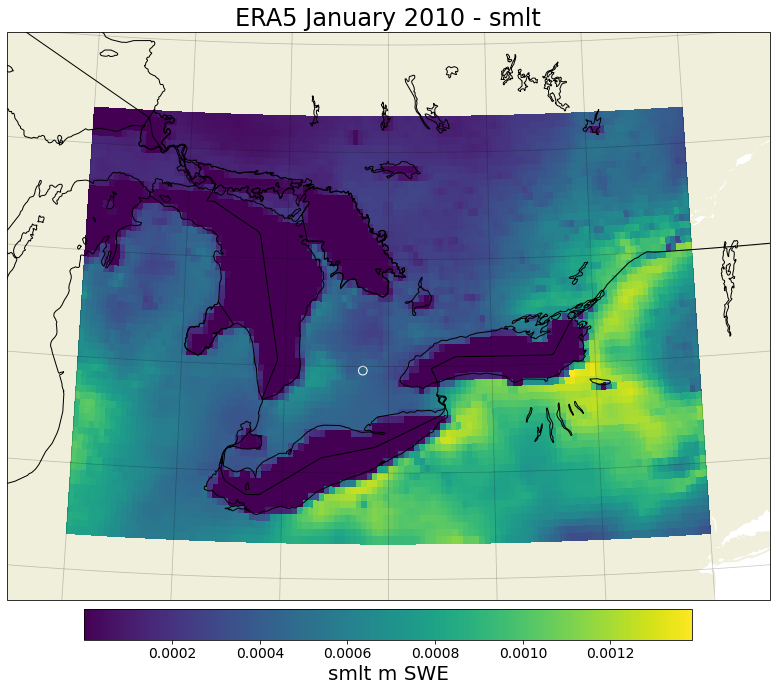

In [ ]:
# Plot data using spatial_plot()
spatial_plot(ds[VAR].values[:][0], lons, lats, min_val, max_val, 'viridis', ("ERA5 January 2010 - " + VAR), (VAR + ' ' + UNITS), False)

What if we wanted to restrict out analysis to just the Canadian portion of the dataset though? This type of masking by political boundary is pretty straightforward in Python (don't jump straight to CDO... we aren't leaving this notebook in this tutorial). 

## Regionmask

The **regionmask** package turns out to be a great option for masking climate data over different regions in Python (https://regionmask.readthedocs.io/en/stable/). In our case, let's select the Canadian region and mask our dataset to only show Ontario data.

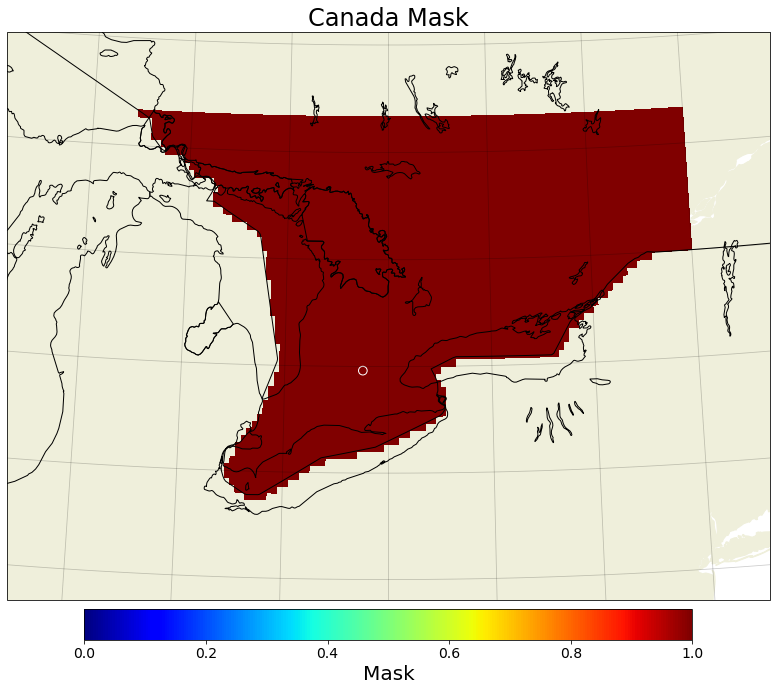

In [ ]:

canada_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(lons, lats)
canada_mask = canada_mask.where(canada_mask == 3) # 3 is Canada ID
canada_mask = canada_mask / 3 
canada_mask = canada_mask.values

spatial_plot(canada_mask, lons, lats, 0, 1, 'jet', "Canada Mask", "Mask", False)


And if we multiply our original ERA5-L dataset by the mask, we get the correct output.

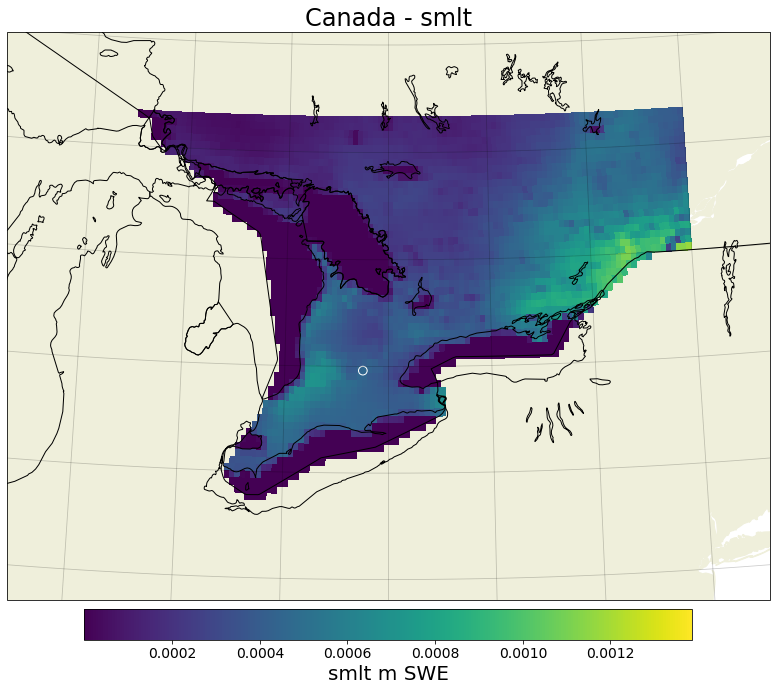

In [ ]:
masked_var = ds[VAR].values[:][0] * canada_mask

spatial_plot(masked_var, lons, lats, min_val, max_val, 'viridis', ("Canada - " + VAR), (VAR + ' ' + UNITS), False)

Let's take this one step further though since not all areas you will want to work on are as formally defined as a Country's borders. What if you have a shapefile of an area (like a Watershed?) that you want to examine for instance?

## rioxarray

Well, we can also handle this in Python using **rioxarray**. This package extends Xarray using the rio prefix to add rasterio capabilities like reprojecting, clipping and merging geospatial data to Xarray (https://corteva.github.io/rioxarray/stable/index.html). 

In [ ]:

# Let's open up the shapefile for the Grandriver watershed we downloaded earlier
# we need to reproject it to WGS84 using another helpful package (geopandas) 
geodf = gpd.read_file(shape_file_path)
gdf = geodf.to_crs('epsg:4326') # use for plotting later on

# Next, we use rioxarray to open the ERA5-L data again and it the CRS to WGS84
datasets = rxr.open_rasterio(data_file_path, mask_and_scale=True)
datasets.rio.write_crs("epsg:4326", inplace=True)

# The following code snippit performs the clipping of the ERA5-L data to the 
# watershed shapefile and does some cleanup on the time index for later
clipped_netcdf = datasets.rio.clip(geodf.geometry.values, geodf.crs)
clipped_lats = clipped_netcdf.y
clipped_lons = clipped_netcdf.x
datetimeindex = clipped_netcdf.indexes['time'].to_datetimeindex()
clipped_netcdf['time'] = datetimeindex
feature_names = [i for i in clipped_netcdf.data_vars]


What does this new clipped dataset look like? Well, as you can see, it's still an Xarray object, but now with a smaller spatial domain.

In [ ]:
clipped_netcdf

<xarray.Dataset>
Dimensions:      (y: 15, x: 14, time: 132)
Coordinates:
  * y            (y) float64 44.2 44.1 44.0 43.9 43.8 ... 43.1 43.0 42.9 42.8
  * x            (x) float64 -80.9 -80.8 -80.7 -80.6 ... -79.9 -79.8 -79.7 -79.6
  * time         (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, y, x) float32 nan nan nan nan nan ... nan nan nan 275.2
    tp           (time, y, x) float32 nan nan nan nan ... nan nan nan 0.003175
    rsn          (time, y, x) float32 nan nan nan nan nan ... nan nan nan 100.0
    sde          (time, y, x) float32 nan nan nan nan nan ... nan nan nan 0.0
    sf           (time, y, x) float32 nan nan nan nan ... nan nan nan 0.001453
    smlt         (time, y, x) float32 nan nan nan nan ... nan nan nan 1.863e-09
    slhf         (time, y, x) float32 nan nan nan nan ... nan nan nan -5.148e+06
    ssr          (time, y, x) float32 nan nan nan nan ... nan nan nan 3.608e+06
    str          (time, y, x) float32 nan nan nan nan ... nan nan nan -4.408e+06
    sshf         (time, y, x) float32 nan nan nan nan ... nan nan nan -2.507e+06
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sat Nov 26 20:54:55 2022: cdo sellonlatbox,-86,-74,41,47 da...

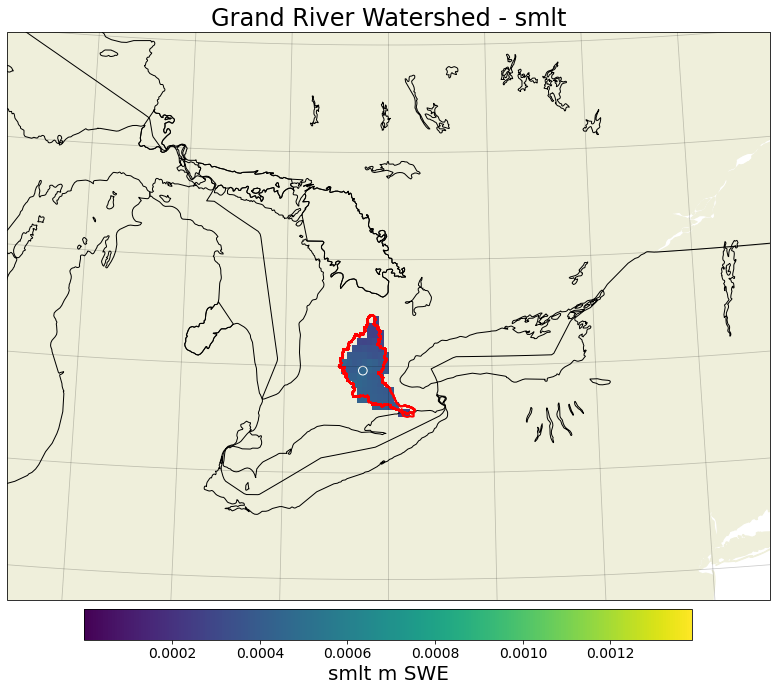

In [ ]:
# Let's plot the clipped domain values now
spatial_plot(clipped_netcdf[VAR].values[:][0], clipped_lons, clipped_lats, min_val, max_val, 'viridis', ("Grand River Watershed - " + VAR), (VAR + ' ' + UNITS), True)


# Checking Assumptions

We can also look at some of the temporal properties of the dataset (e.g. monthly or annual means). The pandas **groupby()** command is a really useful operation for quickly splitting a dataframe, applying a function, and combining the results. We can use this for calculating means in this example and will perform a spatial analysis using this method later on.

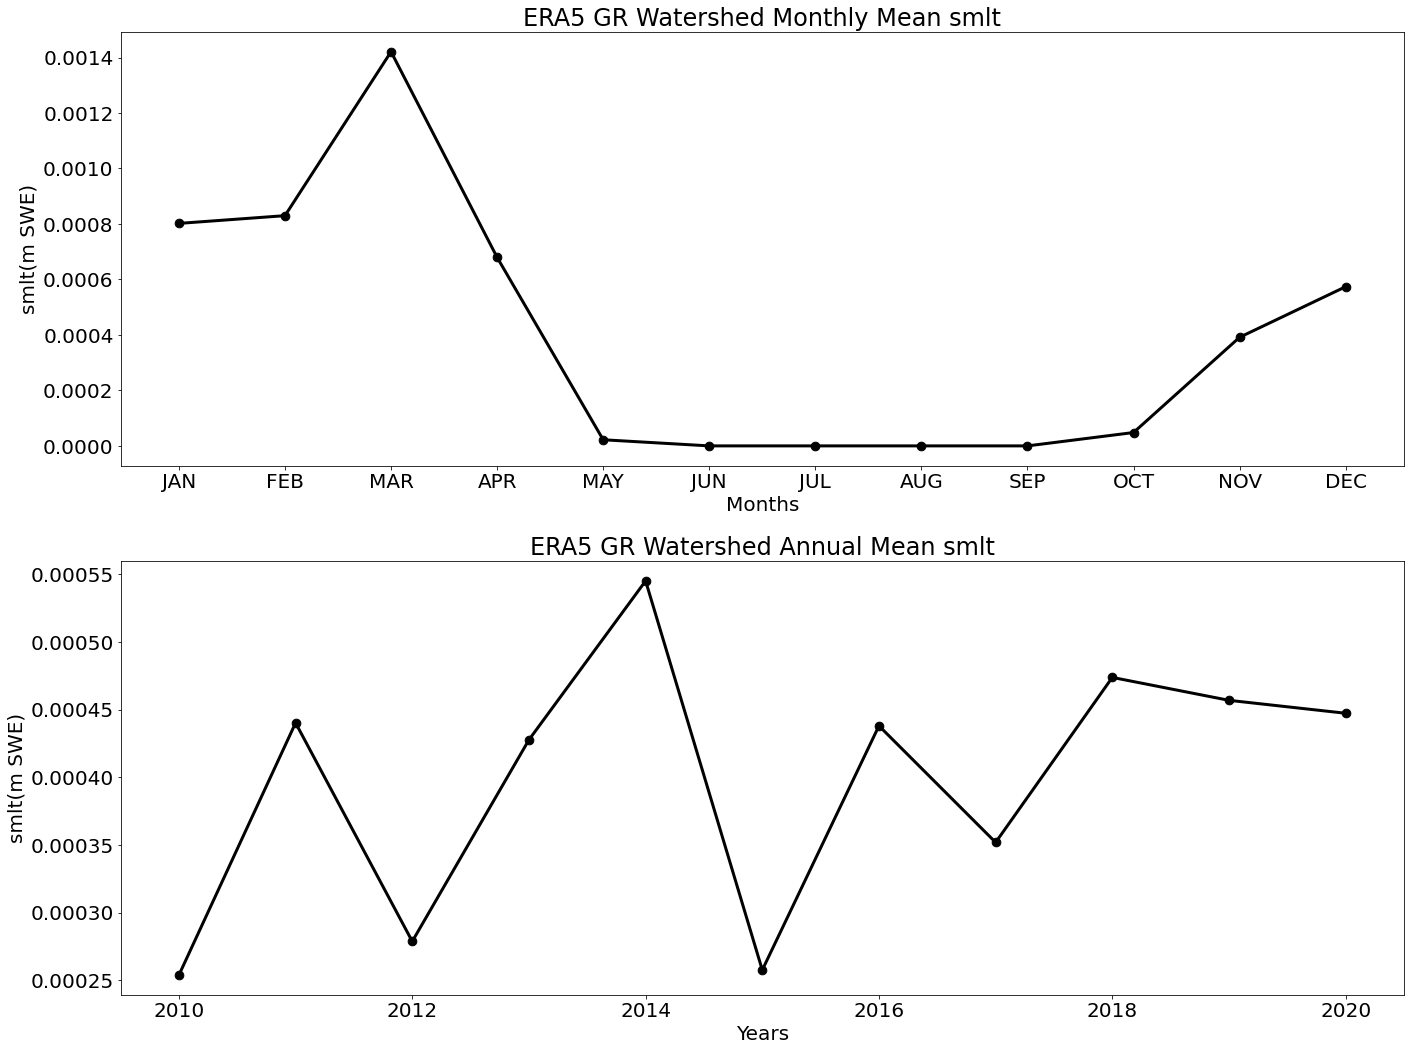

In [ ]:
# Monthly means
avgs = clipped_netcdf.groupby("time.month").mean()
reshaped_avgs = avgs[VAR].values.reshape(avgs[VAR].shape[0], -1)

# Annual means
annual_avgs = clipped_netcdf.groupby("time.year").mean()
reshaped_annual_avgs = annual_avgs[VAR].values.reshape(annual_avgs[VAR].shape[0], -1)

# Then we can plot both of these together in a matplotlib multiplot
fig, axs = plt.subplots(2, figsize=(20, 15))
axs[0].set_title('ERA5 GR Watershed Monthly Mean ' + VAR)
axs[0].set_ylabel(VAR + '(' + UNITS + ')')
axs[0].set_xlabel('Months')
axs[0].plot(MONTHS, np.nanmean(reshaped_avgs, 1), color='black', linewidth=3)
axs[0].scatter(MONTHS, np.nanmean(reshaped_avgs, 1), s=75, color='black')
axs[1].set_title('ERA5 GR Watershed Annual Mean ' + VAR)
axs[1].set_ylabel(VAR + '(' + UNITS + ')')
axs[1].set_xlabel('Years')
axs[1].plot(YEARS, np.nanmean(reshaped_annual_avgs, 1), color='black', linewidth=3)
axs[1].scatter(YEARS, np.nanmean(reshaped_annual_avgs, 1), s=75, color='black')
plt.tight_layout()
plt.show()


We should also take a look how different climate variables are related to one another before we do any sort of regression. This step is important for checking for statistical conditions and to gain early insight into which variables might be useful predictors in our regression models (more on this later).

You can check for conditions in multiple ways (for instance a scatter matrix could be useful). Below, we show how you calculate a correlation matrix between all the values to see how different variables are related to one another.

How would you plot a covariance matrix here?

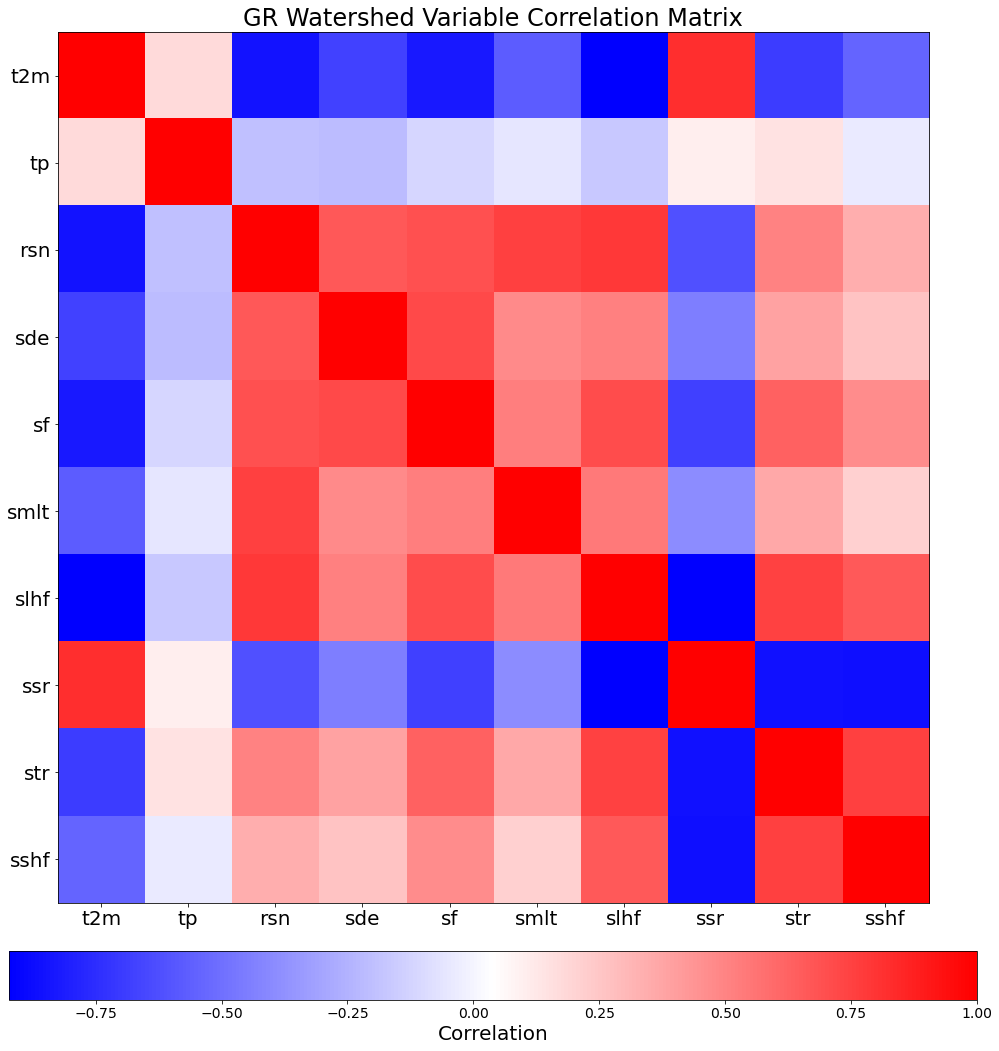

,t2m,tp,rsn,sde,sf,smlt,slhf,ssr,str,sshf
t2m,1.000000,0.176599,-0.853680,-0.671757,-0.827746,-0.570789,-0.921760,0.824086,-0.691752,-0.541963
tp,0.176599,1.000000,-0.200305,-0.210127,-0.111343,-0.053865,-0.166928,0.100587,0.149140,-0.036780
rsn,-0.853680,-0.200305,1.000000,0.662972,0.693266,0.757193,0.785206,-0.620540,0.509642,0.343292
sde,-0.671757,-0.210127,0.662972,1.000000,0.715715,0.475034,0.518107,-0.444120,0.391634,0.262735
sf,-0.827746,-0.111343,0.693266,0.715715,1.000000,0.521026,0.712406,-0.675597,0.628079,0.471284
smlt,-0.570789,-0.053865,0.757193,0.475034,0.521026,1.000000,0.541139,-0.395971,0.368398,0.214643
slhf,-0.921760,-0.166928,0.785206,0.518107,0.712406,0.541139,1.000000,-0.919217,0.745495,0.658344
ssr,0.824086,0.100587,-0.620540,-0.444120,-0.675597,-0.395971,-0.919217,1.000000,-0.855262,-0.867957
str,-0.691752,0.149140,0.509642,0.391634,0.628079,0.368398,0.745495,-0.855262,1.000000,0.756845
sshf,-0.541963,-0.036780,0.343292,0.262735,0.471284,0.214643,0.658344,-0.867957,0.756845,1.000000


In [ ]:
# Need to do some dataframe cleanup first
clipped_df = clipped_netcdf.to_dataframe()
clipped_df.dropna(inplace=True)
clipped_df.drop(columns=['spatial_ref'], inplace=True)

# Plot the correlation matrix. The key here is the clipped_df.corr() call in pandas
fig, ax = plt.subplots(figsize=(15, 15))
im = plt.imshow(clipped_df.corr(), cmap='bwr')
plt.xticks(np.arange(0, len(feature_names)))
plt.yticks(np.arange(0, len(feature_names)))
ax.set_xticklabels((feature_names))
ax.set_yticklabels((feature_names))
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, orientation="horizontal")
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xlabel('Correlation')
plt.title("GR Watershed Variable Correlation Matrix")
plt.tight_layout()
plt.show()

clipped_df.corr()


# Regression

Alright, so we've done some prelimiary work examining the data we have on hand (always an important first step). But now we want to perform a regression analysis to see how well we can predict snowmelt using the other predictors from ERA5-L.

Let's first perform an ordinary least squares (OLS) multiple linear regression (MLR) to define a baseline regression model we can compare with using machine learning. It is usually a good idea to start with a less sophisticated model and work your way up to higher complexities as necessary.

Further, let's perform this analysis on the Grand River watershed dataset so models train quickly. You can test this on the whole dataset later on at your leisure.

In [ ]:
# We need to reshape the clipped watershed dataset to a row-based structure using reset_index. 
# This is a **key step** as supervised methods like the ones we use here, expect the data in this
# row format to work correctly.
reshaped_df = clipped_df.reset_index(drop=False) 

# We also add a month column to see if this is a useful source of temporal information to the model
reshaped_df['month'] = reshaped_df['time'].dt.month

reshaped_df

,y,x,time,t2m,tp,rsn,sde,sf,smlt,slhf,ssr,str,sshf,month
0,44.2,-80.3,2010-01-01,265.233215,0.001354,192.486969,0.372837,1.038870e-03,2.938472e-04,-619900.0,3995780.0,-3313782.0,-4.702113e+05,1
1,44.2,-80.3,2010-02-01,264.904785,0.001441,210.063614,0.386570,1.435220e-03,1.862645e-09,-515281.0,5805512.0,-3812234.5,-1.898675e+06,2
2,44.2,-80.3,2010-03-01,273.983276,0.001150,221.306046,0.199389,4.398245e-04,3.666583e-03,-1322900.0,11103073.0,-5373196.0,-2.908382e+06,3
3,44.2,-80.3,2010-04-01,281.218842,0.001712,164.335510,0.002035,1.603458e-04,1.929477e-04,-4333619.0,17256262.0,-6499573.0,-5.521034e+06,4
4,44.2,-80.3,2010-05-01,286.662537,0.003267,134.560440,0.001019,8.186698e-05,7.493794e-05,-6963502.0,17895346.0,-5517247.0,-4.395197e+06,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10423,42.8,-79.6,2020-08-01,295.633789,0.003976,99.999985,0.000000,-1.862645e-09,1.862645e-09,-12556499.0,20082900.0,-7311120.5,-1.662409e+06,8
10424,42.8,-79.6,2020-09-01,291.372772,0.001834,99.999985,0.000000,-1.862645e-09,1.862645e-09,-10316865.0,15424926.0,-6934157.0,-1.586896e+06,9
10425,42.8,-79.6,2020-10-01,284.911499,0.003361,99.999985,0.000000,-1.862645e-09,1.862645e-09,-6673999.0,8680886.0,-5350981.0,-1.102923e+06,10
10426,42.8,-79.6,2020-11-01,281.210327,0.003095,99.999985,0.000000,9.259395e-05,1.862645e-09,-4775900.0,6322004.0,-5513082.0,-4.719275e+05,11


We then break this reshaped dataset in a set of predictors (X) and a response variable (y) for our models.

In [ ]:
feature_names_all = ['y', 'x', 'month', 't2m', 'tp', 'rsn', 'sde', 'sf', 'slhf', 'ssr', 'str', 'sshf'] # predictors
X = reshaped_df[feature_names_all]
X['x'] = X['x'] + 360 # adjust lons to positive for simplicity
y = reshaped_df['smlt'] # response (snowmelt)


<ipython-input-17-e4c7da1f3908>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['x'] = X['x'] + 360 # adjust lons to positive for simplicity


We can look at each of these dataframes individually to confirm that they have the correct data. Note that month should probably be an indicator variaible since it is catagorical, however we will see why this isn't actually a huge problem in this example later on.

In [ ]:
X

,y,x,month,t2m,tp,rsn,sde,sf,slhf,ssr,str,sshf
0,44.2,279.7,1,265.233215,0.001354,192.486969,0.372837,1.038870e-03,-619900.0,3995780.0,-3313782.0,-4.702113e+05
1,44.2,279.7,2,264.904785,0.001441,210.063614,0.386570,1.435220e-03,-515281.0,5805512.0,-3812234.5,-1.898675e+06
2,44.2,279.7,3,273.983276,0.001150,221.306046,0.199389,4.398245e-04,-1322900.0,11103073.0,-5373196.0,-2.908382e+06
3,44.2,279.7,4,281.218842,0.001712,164.335510,0.002035,1.603458e-04,-4333619.0,17256262.0,-6499573.0,-5.521034e+06
4,44.2,279.7,5,286.662537,0.003267,134.560440,0.001019,8.186698e-05,-6963502.0,17895346.0,-5517247.0,-4.395197e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
10423,42.8,280.4,8,295.633789,0.003976,99.999985,0.000000,-1.862645e-09,-12556499.0,20082900.0,-7311120.5,-1.662409e+06
10424,42.8,280.4,9,291.372772,0.001834,99.999985,0.000000,-1.862645e-09,-10316865.0,15424926.0,-6934157.0,-1.586896e+06
10425,42.8,280.4,10,284.911499,0.003361,99.999985,0.000000,-1.862645e-09,-6673999.0,8680886.0,-5350981.0,-1.102923e+06
10426,42.8,280.4,11,281.210327,0.003095,99.999985,0.000000,9.259395e-05,-4775900.0,6322004.0,-5513082.0,-4.719275e+05


In [ ]:
y

0        2.938472e-04
1        1.862645e-09
2        3.666583e-03
3        1.929477e-04
4        7.493794e-05
             ...     
10423    1.862645e-09
10424    1.862645e-09
10425    1.862645e-09
10426    1.862645e-09
10427    1.862645e-09
Name: smlt, Length: 10428, dtype: float32

## scikit-learn

Next, we need to split the data into training, testing and validation data. There are multiple methods for doing this, but I prefer the scikit-learn **train_test_split()** method (https://scikit-learn.org/stable/). 

You may wonder what the validation data is used for? Well this is a set of unseen holdback data we use to evaluate the final tuned model performance. Right now we can define it and set it aside, but it will be important later.

In [ ]:
X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE) # save validation data for later

X_validation

,y,x,month,t2m,tp,rsn,sde,sf,slhf,ssr,str,sshf
10347,42.8,280.4,4,276.386047,0.005050,99.999985,0.000000,1.846235e-04,-430588.0,14780316.0,-3544611.5,1783180.250
6070,43.4,279.4,11,278.795624,0.002563,160.944092,0.014751,8.655358e-04,-1842123.0,5528676.0,-4712989.5,826675.875
10109,42.9,280.3,6,292.611603,0.001535,100.021347,0.000000,-1.862645e-09,-9433964.0,22493030.0,-7369782.5,-5004454.000
7637,43.2,279.5,6,291.291107,0.004346,100.021347,0.000000,-1.862645e-09,-8450872.0,18655514.0,-5760572.5,-3431827.750
9839,43.0,280.1,12,278.123474,0.001861,152.804688,0.002035,1.496188e-04,-1132481.0,3533549.0,-3411320.5,533775.000
...,...,...,...,...,...,...,...,...,...,...,...,...
4618,43.5,279.1,11,278.654388,0.002772,159.822510,0.014751,9.073168e-04,-1860943.0,5485468.0,-4633848.0,784914.625
7682,43.2,279.6,3,279.959595,0.001826,139.014679,0.010683,2.653617e-04,-2871159.0,12350090.0,-5268021.0,-3207575.750
4271,43.6,279.8,12,268.117554,0.002928,157.130737,0.107325,1.215590e-03,-577277.0,3253699.0,-3240888.5,-308887.000
1347,43.9,279.8,4,277.648712,0.001605,165.403671,0.012716,6.899443e-04,-3587444.0,15136534.0,-6056312.0,-4864868.000


In order to fit our MLR model, we use a k-fold cross validation (CV) technique to examine model robustness using different portions of the training dataset. This is where the RANDOM_STATE and N_SPLITS variables we defined earlier come into play. 

Again we use scikit-learn builtins (KFold and kf.split()) to break the non-validation data up into different train/test splits (in this case 80/20 splits because N_SPLITS is 5).

## SciPy

We then use the Python SciPy package's OLS regression method to fit the MLR model (https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html). Note that scikit-learn also includes a method for performing linear regression, but I prefer SciPy for this example because of the in depth model.summary() metrics it provides.

In [ ]:
kf = KFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True)

split_count = 0
mlr_best_model = -1
mlr_lowest_rmse = np.inf
mlr_best_split = -1

# Iterate through each fold
for train_index, test_index in kf.split(X):
    print("On split", split_count)
    print("TRAIN:", train_index, "TEST:", test_index)
    
    # Split the data into train/test based on current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # iloc important
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #### Perform OLS MLR
    X_train = sm.add_constant(X_train) # Must add intercept first for OLS
    X_test = sm.add_constant(X_test) 
    mlr_model = sm.OLS(y_train, X_train).fit() # fit model

    # Uncomment the below line for additional info into each regression fit
    # print(mlr_model.summary())

    # Make prediction
    y_pred_mlr = mlr_model.predict(X_test)

    print("\nSTATISTICS")
    print("MEAN ABSOLUTE ERROR:", abs(np.nanmean(y_pred_mlr) - np.nanmean(y_test)))
    print("CORRELATION:", np.corrcoef(y_pred_mlr, y_test)[0][1])
    print("RMSE:", mean_squared_error(y_pred_mlr, y_test, squared=False))
    print("R^2:", r2_score(y_pred_mlr, y_test))

    # Save best performing model
    if mean_squared_error(y_pred_mlr, y_test, squared=False) < mlr_lowest_rmse:
      mlr_lowest_rmse = mean_squared_error(y_pred_mlr, y_test, squared=False)
      mlr_best_model = mlr_model
      mlr_best_split = split_count

    split_count += 1

print("\nFinal Results:")
print("BEST MODEL", mlr_best_split)
print("With RMSE", mlr_lowest_rmse)


On split 0
TRAIN: [     1      2      3 ... 974288 974290 974291] TEST: [     0      7     10 ... 974281 974283 974289]

STATISTICS
MEAN ABSOLUTE ERROR: 9.679079448579077e-07
CORRELATION: 0.8209305170948412
RMSE: 0.0005128860562092025
R^2: 0.5162421676626561
On split 1
TRAIN: [     0      1      3 ... 974288 974289 974291] TEST: [     2      6      9 ... 974276 974284 974290]

STATISTICS
MEAN ABSOLUTE ERROR: 9.67047915037165e-07
CORRELATION: 0.8206406572282078
RMSE: 0.0005102027902516908
R^2: 0.5186150077003849
On split 2
TRAIN: [     0      1      2 ... 974288 974289 974290] TEST: [    11     26     29 ... 974279 974287 974291]

STATISTICS
MEAN ABSOLUTE ERROR: 1.2107461529443052e-06
CORRELATION: 0.8235234576596769
RMSE: 0.0005124550136266312
R^2: 0.5183041160452779
On split 3
TRAIN: [     0      2      3 ... 974289 974290 974291] TEST: [     1      4     16 ... 974264 974280 974282]

STATISTICS
MEAN ABSOLUTE ERROR: 8.175062343108888e-07
CORRELATION: 0.8224207633986559
RMSE: 0.00050901

Alright, we can see from the above printed statistics that we get pretty good performance with the MLR model (correlations around 0.8). Not bad! But can we do better with a nonlinear method?

## The Random Forest

Let's take a look at scikit-learn's RandomForestRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). I won't get into the inner workings/mechanics of how Random Forest's operate here, but if you are interested in learning more, check out this great TowardsDataScience post (https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

## Hyperparameterization

An important part of the machine learning process is tuning your model with the proper hyperparameters. Note that these "parameters" differ from internal model parameters which are updated during training. Hyperparameters are defined before the training begins and are static throughout. The parameters typically control how the model "learns" over time, and for a random forest, it includes things like the number of trees in the forest, tree depth, number of leaves, splitting methods etc. Finding the optimal hyperparameters is critical for developing a model with little overfitting (i.e. a robust model) with good performance.

Again, we don't have time to go into all of the details for this method here, but you should check out the following link for more details on different hyperparameterization techniques (https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac).
 

In [ ]:
# Let's define a parameter grid to test for the RF
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 250, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 4, 5, 6]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [25, 81, 137, 193, 250],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 3, 4, 5, 6],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

We can use scikit-learn's RandomizedSearchCV to test NUM_ITERS * 5 (since we use a testing set size of 0.2) models and see which performs best with different values selected in the random_grid defined above. Note that the more iterations you define, the longer this process takes. In this case, the default 10
iterations should take a minute or two to perform.

In [ ]:
NUM_ITERS = 10
TEST_SIZE = 0.2

X_hyper_train, X_hyper_test, y_hyper_train, y_hyper_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

rf = RandomForestRegressor()

# Perform the hyperparameterization (note that n_jobs=-1 means use all available processors)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = NUM_ITERS, cv = N_SPLITS, verbose=2, random_state=RANDOM_STATE, n_jobs = -1)
rf_random.fit(X_hyper_train, y_hyper_train)

# Print out the best fit params
rf_random.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 137,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 6,
 'bootstrap': False}

Did this hyperparameterization process really make a difference though? Well, we can compare our hyperparameter results to the default model and see...

In [ ]:
def evaluate(model, test_features, y_test, title):
    predictions = model.predict(test_features)
    print("\n" + title)
    print("MEAN ABSOLUTE ERROR:", abs(np.nanmean(predictions) - np.nanmean(y_test)))
    print("CORRELATION:", np.corrcoef(predictions, y_test)[0][1])
    print("RMSE:", mean_squared_error(predictions, y_test, squared=False))
    print("R^2:", r2_score(predictions, y_test))

base_model = RandomForestRegressor(n_estimators = 100, max_depth=4, random_state = RANDOM_STATE)
base_model.fit(X_hyper_train, y_hyper_train)
evaluate(base_model, X_hyper_test, y_hyper_test, "DEFAULT MODEL")

rf_best_model = rf_random.best_estimator_
evaluate(rf_best_model, X_hyper_test, y_hyper_test, "BEST_MODEL")



DEFAULT MODEL
MEAN ABSOLUTE ERROR: 6.132303731524579e-06
CORRELATION: 0.9045661004864511
RMSE: 0.0002566971591394095
R^2: 0.7470241618782634

BEST_MODEL
MEAN ABSOLUTE ERROR: 8.407462386634287e-06
CORRELATION: 0.9316520058397858
RMSE: 0.00022011401206728504
R^2: 0.8222327637205694


We do see an improvement in the R^2 of nearly 0.1, which is great!

With both the MLR and RF models trained, we now use that validation data we swet aside earlier. Neither model has used this data for training and is completely unseen. Let's see how each model performs here (you hope to see similar performance to the previous results).

In [ ]:
# Test final model on validation data
X_validation = sm.add_constant(X_validation)
y_pred_mlr = mlr_best_model.predict(X_validation)

y_pred_rf = rf_best_model.predict(X_validation.drop(columns=['const']))

# Package everything together nicely into a dataframe using Pandas
df = pd.DataFrame(data={'x': X_validation['x'], 'y': X_validation['y'], 'month': X_validation['month'], 
                        'y_pred_mlr': y_pred_mlr, 'y_pred_rf': y_pred_rf, 'y_test': y_validation})

# Print out statistics
print("\nSTATISTICS MLR:")
print("MEAN ABSOLUTE ERROR:", abs(np.nanmean(y_pred_mlr) - np.nanmean(y_validation)))
print("CORRELATION:", np.corrcoef(y_pred_mlr, y_validation)[0][1])
print("RMSE:", mean_squared_error(y_pred_mlr, y_validation, squared=False))
print("R^2:", r2_score(y_pred_mlr, y_validation))

print("\nSTATISTICS RF:")
print("MEAN ABSOLUTE ERROR:", abs(np.nanmean(y_pred_rf) - np.nanmean(y_validation)))
print("CORRELATION:", np.corrcoef(y_pred_rf, y_validation)[0][1])
print("RMSE:", mean_squared_error(y_pred_rf, y_validation, squared=False))
print("R^2:", r2_score(y_pred_rf, y_validation))

df




STATISTICS MLR:
MEAN ABSOLUTE ERROR: 1.3982693758436064e-05
CORRELATION: 0.8244939942944248
RMSE: 0.00038067841659414516
R^2: 0.46593810974119987

STATISTICS RF:
MEAN ABSOLUTE ERROR: 1.364752270028403e-05
CORRELATION: 0.9428535425320147
RMSE: 0.0002274619258760991
R^2: 0.851493292837379


,x,y,month,y_pred_mlr,y_pred_rf,y_test
10347,280.4,42.8,4,0.000519,7.276667e-06,1.862645e-09
6070,279.4,43.4,11,0.000969,8.356942e-04,7.900801e-04
10109,280.3,42.9,6,-0.000283,1.779196e-07,1.862645e-09
7637,279.5,43.2,6,-0.000071,1.779196e-07,1.862645e-09
9839,280.1,43.0,12,0.000555,1.084971e-04,1.079813e-04
...,...,...,...,...,...,...
4618,279.1,43.5,11,0.000954,9.394743e-04,8.054227e-04
7682,279.6,43.2,3,0.000585,4.988978e-04,5.174764e-04
4271,279.8,43.6,12,0.000290,6.805512e-04,3.345609e-04
1347,279.8,43.9,4,0.000863,5.392257e-04,6.484687e-04


They are quite similar which is great!

## Model Intercomparisons

Let's plot the monthly means and see how things look temporally with the predicted snowmelt data.

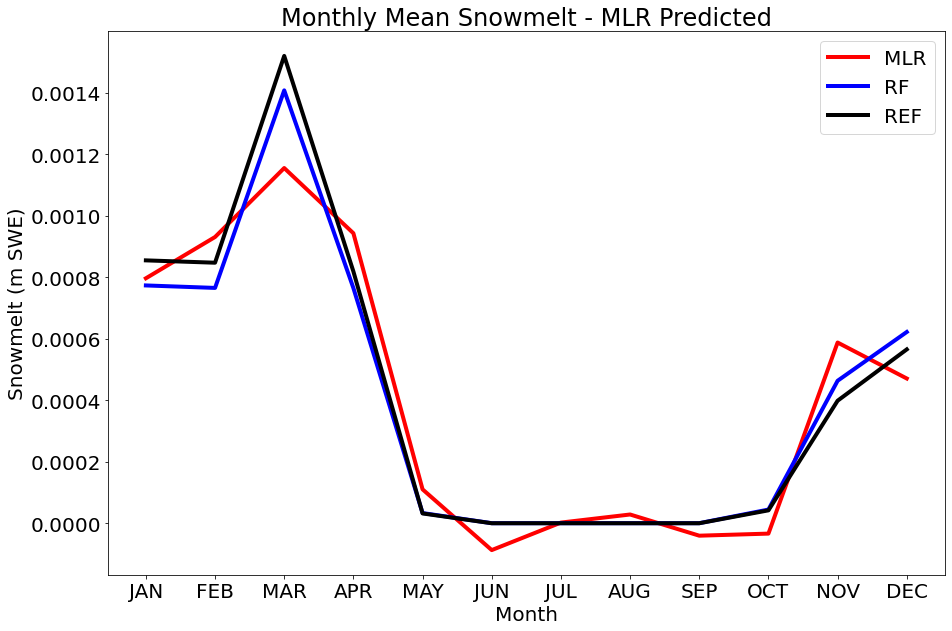

In [ ]:
monthly_means = df.groupby(['month']).mean()

# Plot monthly average snowmelt for each model and ERA5-L
fig, ax = plt.subplots(figsize=(15, 10))
plt.title("Monthly Mean Snowmelt - MLR Predicted")
plt.xlabel("Month")
plt.ylabel("Snowmelt (m SWE)")
plt.plot(MONTHS, monthly_means.y_pred_mlr, color='red', linewidth=4, label="MLR")
plt.plot(MONTHS, monthly_means.y_pred_rf, color='blue', linewidth=4, label="RF")
plt.plot(MONTHS, monthly_means.y_test, color='black', linewidth=4, label="REF")
plt.legend()
plt.show()

Not too bad! The RF definitely does a slightly better job at capturing the March melt event, but the MLR isn't far behind in performance.

We can also take a look at a scatterplot of values. Note how the MLR can produce unphysical negative melt values while the RF cannot. We also see a slightly tighter distribution of values in the RF. Both models are somewhat close to the 1-to-1 line though which is reassuring!

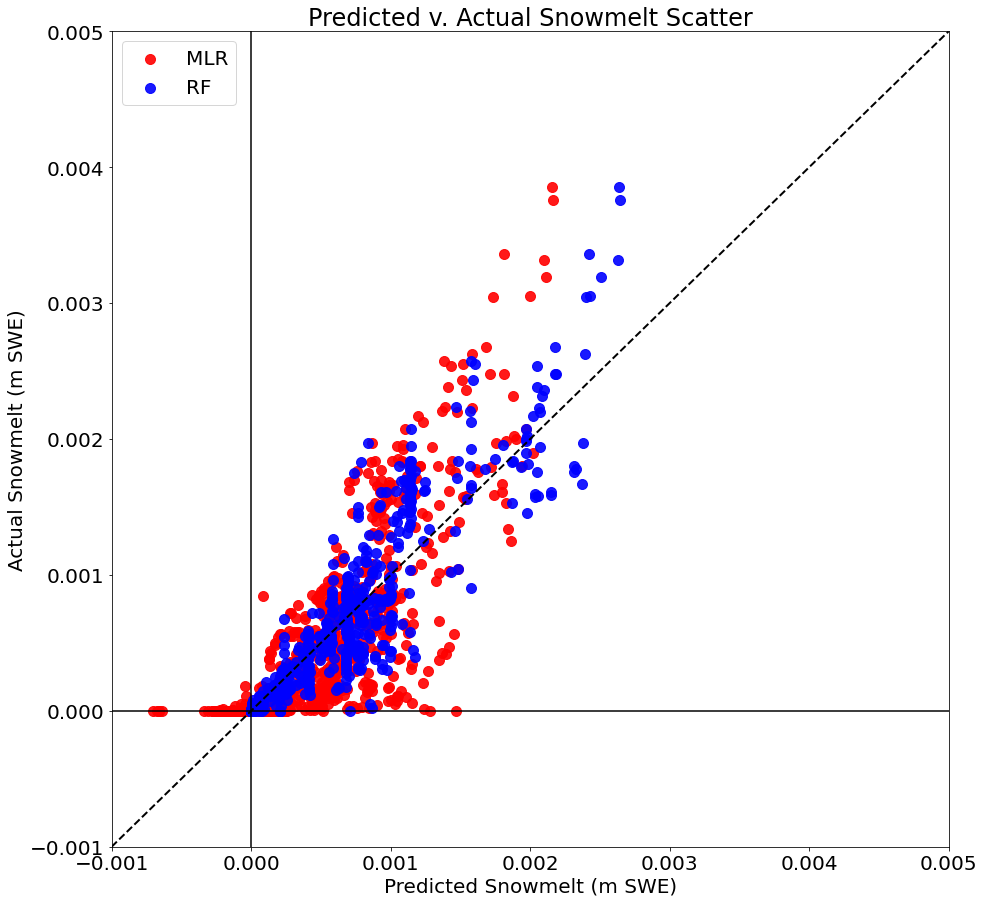

In [ ]:
# Scatterplot of all model predicstions
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Predicted v. Actual Snowmelt Scatter")
plt.xlabel("Predicted Snowmelt (m SWE)")
plt.ylabel("Actual Snowmelt (m SWE)")
plt.xlim(-0.001, 0.005)
plt.ylim(-0.001, 0.005)
plt.scatter(y_pred_mlr, y_validation, color='red', s=100, alpha=0.9, label='MLR')
plt.scatter(y_pred_rf, y_validation, color='blue', s=100, alpha=0.9, label='RF')
plt.plot([-0.001, 0.005], [-0.001, 0.005], linestyle='--', color='black', linewidth=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.legend()
plt.show()

Another really interesting product from the Random Forest are the feature importance scores. These are calculated using a Mean Decrease of Impurity approach (https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3), and give some insight into which inputs are providing the most useful predictive information. You can then use this information to further refine and optimize your model (another great followup excercise for you!).

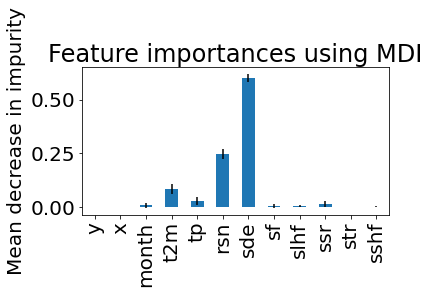

In [ ]:
# Extract feature importances from the best RF model
importances = rf_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_all)

# Plot importance scores in a bar chart
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Out of Sample Prediction

Finally, let's conclude this tutorial with an out-of-sample prediction exercise! **What fun**!

So far, we have limited our training to just the Grand River watershed. But we have so much more data throughout the region to work with. Let's take the models we've trained on the watershed and apply them to our full data domain and see how they do. 

Before running these cell blocks, think about the potential issues arising from this sort of test. Do you expect the RF to perform better than the MLR in the United States for instance? How do the models handle areas they have never seen before like Lakes or the Appalachian range? All of these are the sorts of questions you should be asking yourself before performing this type of analysis to set forth some hypotheses.


In [ ]:
# Prepare the full dataset for testing (as we've done before for the clipped region)
out_of_sample_df = ds.to_dataframe()
out_of_sample_df.dropna(inplace=True)
out_of_sample_df = out_of_sample_df.reset_index(drop=False)
out_of_sample_df['month'] = out_of_sample_df['time'].dt.month
out_of_sample_df = out_of_sample_df.rename(columns={'longitude': 'x', 'latitude': 'y'})
X = out_of_sample_df[feature_names_all] # KEY: MAKE SURE THESE ARE IN THE CORRECT ORDER
y = out_of_sample_df['smlt']

# Use the best MLR and RF models for prediction
y_pred_rf = rf_best_model.predict(X)
X = sm.add_constant(X)
y_pred_mlr = mlr_best_model.predict(X)

# Put all of the results into a single dataframe for ease-of-use later
out_of_sample_prediction_df = pd.DataFrame(data={'lat': X['y'], 'lon': X['x'], 
                                                 'y_pred_rf': y_pred_rf, 'y_pred_mlr': y_pred_mlr,
                                                 'y_test': y, 'diff_mlr': (y_pred_mlr - y), 'diff_rf': (y_pred_rf - y)}, index=None)

out_of_sample_prediction_df

,lat,lon,y_pred_rf,y_pred_mlr,y_test,diff_mlr,diff_rf
0,47.000000,274.0,0.000004,-0.001665,1.862645e-09,-0.001665,0.000004
1,46.900002,274.0,0.000004,-0.001618,1.862645e-09,-0.001618,0.000004
2,46.799999,274.0,0.000004,-0.001576,1.862645e-09,-0.001576,0.000004
3,46.700001,274.0,0.000251,-0.000543,2.773292e-05,-0.000571,0.000223
4,46.599998,274.0,0.000282,0.001360,1.422036e-04,0.001218,0.000140
...,...,...,...,...,...,...,...
974287,41.400002,286.0,0.000687,0.000677,1.234980e-03,-0.000558,-0.000548
974288,41.299999,286.0,0.000887,0.000631,1.177745e-03,-0.000547,-0.000291
974289,41.200001,286.0,0.001006,0.000647,1.127589e-03,-0.000481,-0.000121
974290,41.099998,286.0,0.001007,0.000648,1.135850e-03,-0.000488,-0.000128


This time, let's calculate the annual mean snowmelt values at each grid cell and plot these means on a map so we can see spatially-defined differences.

In [ ]:
# Group by lat and lon now
grouped_df = out_of_sample_prediction_df.groupby(['lat','lon']).mean().fillna(0)
grouped_df = grouped_df.round({'lat': 1, 'lon': 1})

lons = ds.longitude.values
lats = np.flip(ds.latitude.values)
default = (np.full((len(lats), len(lons)), np.nan))
rf = (np.full((len(lats), len(lons)), np.nan))
rf_diffs = (np.full((len(lats), len(lons)), np.nan))
mlr = (np.full((len(lats), len(lons)), np.nan))
mlr_diffs = (np.full((len(lats), len(lons)), np.nan))

# Fill grids of values with each mean snowmelt estimate for plotting
w = 0
for index, row in grouped_df.iterrows():
    j = np.where(lats == grouped_df.iloc[w].name[0])[0][0]
    k = np.where(lons == grouped_df.iloc[w].name[1])[0][0]
    default[j][k] = grouped_df.iloc[w].y_test
    rf[j][k] = grouped_df.iloc[w].y_pred_rf
    rf_diffs[j][k] = grouped_df.iloc[w].diff_rf
    mlr[j][k] = grouped_df.iloc[w].y_pred_mlr
    mlr_diffs[j][k] = grouped_df.iloc[w].diff_mlr
    w += 1


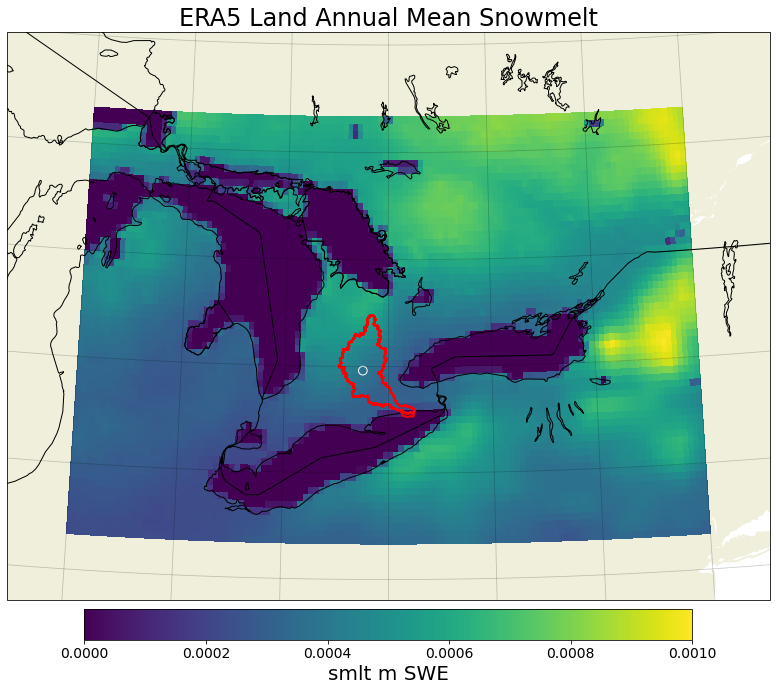

In [ ]:
# Plot ERA5-L Annual Mean Snowmelt values
spatial_plot(default, lons, lats, 0, 0.001, 'viridis', "ERA5 Land Annual Mean Snowmelt", (VAR + ' ' + UNITS), True)

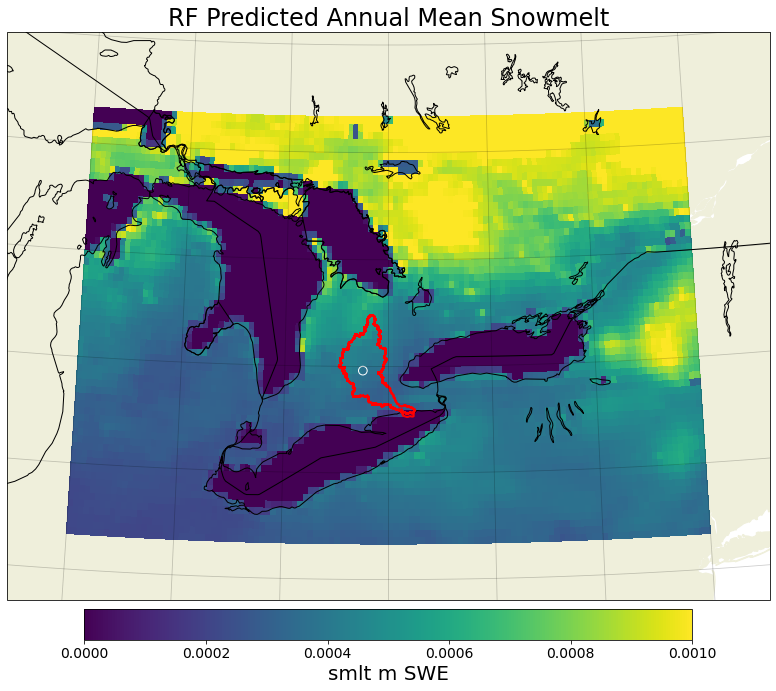

In [ ]:
# Plot RF Annual Mean Snowmelt Predictions
spatial_plot(rf, lons, lats, 0, 0.001, 'viridis', "RF Predicted Annual Mean Snowmelt", (VAR + ' ' + UNITS), True)

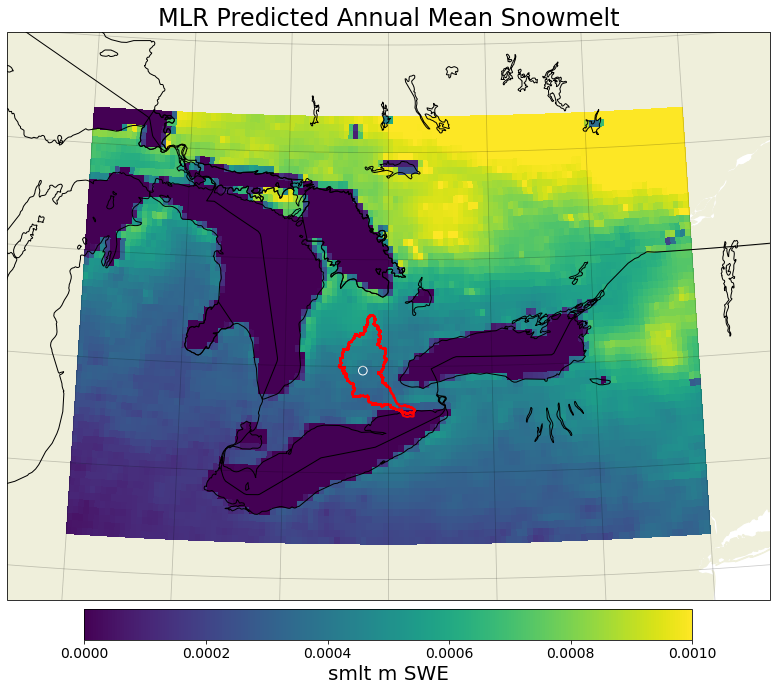

In [ ]:
# Plot MLR Annual Mean Snowmelt Predictions
spatial_plot(mlr, lons, lats, 0, 0.001, 'viridis', "MLR Predicted Annual Mean Snowmelt", (VAR + ' ' + UNITS), True)

Since it's a bit hard to see the differences looking at mean value plots, let's check out the biases.

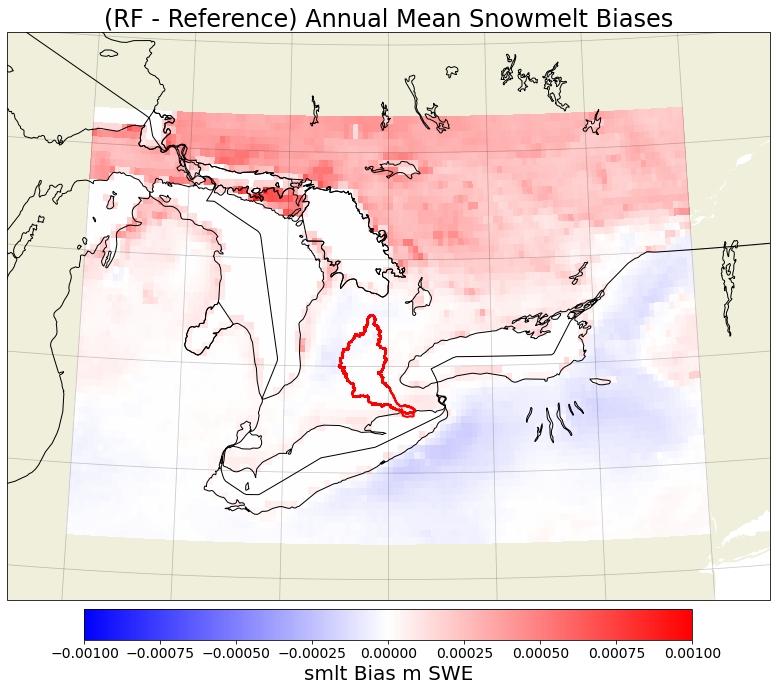

In [ ]:
# Plot RF - Actual Snowmelt Biases
spatial_plot(rf_diffs, lons, lats, -0.001, 0.001, 'bwr', "(RF - Reference) Annual Mean Snowmelt Biases", (VAR + ' Bias ' + UNITS), True)

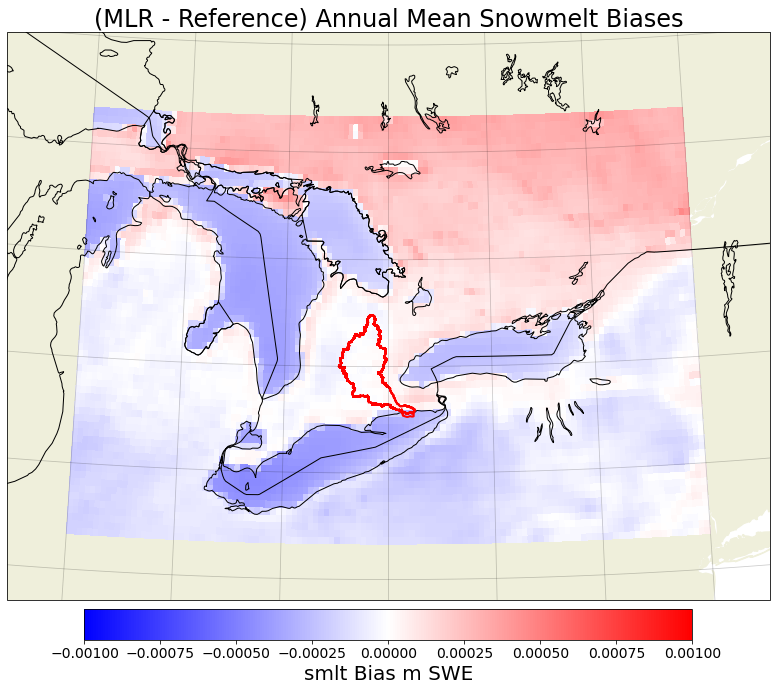

In [ ]:
# Plot MLR - Actual Snowmelt Biases
spatial_plot(mlr_diffs, lons, lats, -0.001, 0.001, 'bwr', "(MLR - Reference) Annual Mean Snowmelt Biases", (VAR + ' Bias ' + UNITS), True)

Wow the RF does a much better job over the lakes and the USA. However, it's maxima saturates more quickly in Northern Ontario where we are unable to accurately model the much higher melt levels in this area (a typical out-of-sample problem).

What other features do you notice?

# Final Notes
Thanks everyone for following along! I hope this gives you some insight into some of the more popular libraries we use in our group, and how these tools can be used for machine learning. 

As always, I'd recommend continued reading on some of the more advanced topics we glossed over earlier. 

If you are looking for a challenge, try completing the following exercises on your own.



# Exercises
*   Try testing different combinations of model inputs based on the feature importances
*   Try expanding your hyperparameter search area (or use a Bayesian approach)
*   Try training the model on the larger spatial domain and see how the output changes
*   Implement a neural network approach and see if it performs any better than the RF
*   Perform prediction on an entirely different climate variable (e.g. Precipitation- much harder!)
*   Change this into a classification problem (e.g. is there snowmelt this month?)

In [ ]:
print("All done!")

All done!
